# Introduction


In this notebook, we will explore machine learning models to predict whether IMDB movie reviews are helpful or not.

Two methodologies were executed to improve the prediction accuracy of a review's helpfulness. These mothodologies can be summarized as follows:

1. **Features Based Model:** Extract some features from the review and build models to predict with these features.

2. **Transfer Learning** Apply a transfer learning approach with `bert` as base model to train and carry out binary classification.

We will compare the performance of different models and select the top performing models for the purpose of ensembling, to develop a final model. Utilising an ensemble model can help achieve a more robust and accurate model.

The following is an overview of the steps related to the analysis of the data:
1. **Clean the data:** Because the reviews text is not all in plain text, in which also contains some unicode and some special characters, we need to identify those characters and remove them.

2. **Split the data:** Due to the unbalanced nature of the dataset, containing 76% data from the majority class (helpful reviews), we aim to generate new data for the minority class (unhelpful reviews) by appliyng augmentation to make the dataset more balanced. However, data augmentation will not be applied to the test dataset. Thus, we will split the dataset into training and test dataset before carrying out any oversampling.

3. **Balance the data:** Apply a synonym augmentation algorithm to triple the number of reviews from the minority class (unhelpful reviews).

4. **Prepare the data:** In this part, we concatenate the training, test dataset and unlabelled dataset together to form a final dataset in order to make predictions on the ulablled test data. Since we intend to retain the split result and not run the augmentation algorithm every time, the final dataset will be exported for convenience. To distinguish the different types of data, we label them with `train`,`test` and `unlabelled` respectively. Moreover, we apply cross validation to evaluate the performance and robustness of the each model. Hence, `StratifiedKFold` is utilised to split the dataset into different folds and labelled with the fold index. The final dataframe will have the following structure:

    |imdb_user_review|helpfulness_cat|simulated|fold|type|
    |--------------|--------------|---------|-----|-----|
    |review1|1|false|1|train|
    |review2|1|false|2|train|
    |review3|0|false|3|train|
    |review4|0|true|3|train|
    |review5|0|false|3|test|
    |...|...|...|...|...|
    |review6||false|nan|unlabelled|

 
&nbsp;

5. **Generate more features:** In this part, we generate numerical features from the text reviews that might be useful to the classification. Enlightened by some research, the features generation will be derived from the following categories:
    - **Lexical features**: Unigram, Bigram, Swear word, etc. (All of the algorithms can be found in the `'modules/features/lexical_features.py'`)
    - **Structural features**: Sentence length, number of words, etc. (All of the algorithms can be found in the `'modules/features/structural_features.py'`)
    - **Syntactic features**: Whether the sentences are complied with the grammar (All of the algorithms can be found in the `'modules/features/syntactic_features.py'`)
    - **Opinion features**: The polarity of the review (positive vs negative, subjective vs objective) (All of the algorithms can be found in the `'modules/features/opinion_features.py'`)
    - **Entailment features**: Whether the reviews have a clear logic. (All of the algorithms can be found in the `'modules/features/entailment_features.py'`)
    - **Topic features**: The probability of a review relating to a certain topic (All of the algorithms can be found in the `'modules/features/topic_features.py'`)

6. **Explore generated features and preprocess:** In this part, we are going to explore more about these numerical features and have a better understanding of how these features could influence the classification.

7. **Train the models:** In this section, we will train the models with the generated features. Followed by tuning the hyperparameters to achieve a higher prediction accuracy for each model. Also, in order to acquire a more stable performance metrics of each model, the models will be trained through cross validation 5 times and record the predictions in each fold.

8. **Ensemble the models:** After training several different models, we will select the top 3 models with the highest performance to develop a more robust model through ensembling. In this case, the contribution of each model towards the final classification will be weighted in the ratio of 1:1:2, where the model with the best performance will be weighted more.

9. **Predict the unlabeled reviews:** 
Once the top 3 models are seleced to ensemble with their corresponding weights, the final ensemble model will be utilised to predict the unlabelled reviews.

In [1]:
import re
import json
import sklearn 
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,classification_report

# import the modules defined by us
from modules.features import *
from modules.augmentation import *
from modules.classification import *
from modules.cross_validation import *
from modules.reduce_dimension import *
from modules.preprocessing import *

# Part 1: Clean the data

According to the observations, a lot of meaningless unicode characters and unnecessary symbols were found in the reviews, and hence will be removed. Moreover, all text will be converted to lowercase before feeding into an NLP pipeline in the next step.

Here is an example of a review before and after the cleaning:

In [2]:
# drop duplicates
dfm  = pd.read_csv('data/train.csv').drop_duplicates()
reviews = dfm['imdb_user_review'].tolist()
print("Sample reviews:" ,reviews[9])

Sample reviews: Once again Chaplin plays his famous creation, the beloved Tramp\u0085 The noble Little Fellow meets and falls in love with a blind flower girl\u0085 She assumes he is wealthy man and offers him a flower, which he attentively accepts with his last penny\u0085 One night by chance he rescues a drunken millionaire from drowning\u0085 The rich gentleman becomes a generous friend when drunk but doesn't recognize the tramp when sober\u0085 Chaplin takes the blind girl under his wing, and takes flight with the millionaire's money to cure her blindness\u0085 \"City Lights\" engaged a true genius in a graceful and touching performance which arouses profound feelings and joy with great simplicity of style and tragic tale\u0085 Each scene was the result of hard-working detail and planning


In [3]:
# preprocess the reviews
preprocessing = Preprocessing(reviews)
reviews  = preprocessing.preprocess()
print('Preprocessing Done...')
print('-----------------------------------------------------')
print(reviews[9])

Replacing unicode...
Lowering case...
Removing special symbols...
Replacing unicode...
Lowering case...
Removing special symbols...
Preprocessing Done...
-----------------------------------------------------
once again chaplin plays his famous creation, the beloved tramp. the noble little fellow meets and falls in love with a blind flower girl. she assumes he is wealthy man and offers him a flower, which he attentively accepts with his last penny. one night by chance he rescues a drunken millionaire from drowning. the rich gentleman becomes a generous friend when drunk but doesn't recognize the tramp when sober. chaplin takes the blind girl under his wing, and takes flight with the millionaire's money to cure her blindness.  "city lights " engaged a true genius in a graceful and touching performance which arouses profound feelings and joy with great simplicity of style and tragic tale. each scene was the result of hard-working detail and planning


# Part 2: Split the data

`Stratified Split` was utilised to split the dataset into training and test dataset (70% and 30% respectively). This ensures that the proportion of the classes are the same in the training and test dataset.

In [4]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(dfm['imdb_user_review'], dfm['helpfulness_cat'], test_size=0.3, random_state=42,stratify=dfm['helpfulness_cat'])
print(f"Train classification: {y_train.mean()}")
print(f"Test classification: {y_test.mean()}")

Train classification: 0.7636508569151056
Test classification: 0.7638673690734429


# Part 3: Oversample the data

The dataset is imbalanced, where the majority class (helpful reviews) represents 76% of the data while the minority class (unhelpful reviews) is 24%. According to Pozzolon et al (2019)., and Donicke et al (2015)., imbalanced data in text classification has a large negative impact on model performance, especially the performance for classifying the minority class.

The downside of undersampling would be the loss of important features, therefore we opted to oversample to balance the data. A synonym augmentation algorithm was utilised to oversample the minority class, the algorithm was applied twice to triple the size.

Here is an example output of the synonym augmentation algorithm:

In [5]:
# example of augmentation
print('Raw review:')
print(reviews[9])
print('-----------------------------------------------------')
print('Augmented review:')
Augmentation.synonym_aug_text(reviews[9])

Raw review:
once again chaplin plays his famous creation, the beloved tramp. the noble little fellow meets and falls in love with a blind flower girl. she assumes he is wealthy man and offers him a flower, which he attentively accepts with his last penny. one night by chance he rescues a drunken millionaire from drowning. the rich gentleman becomes a generous friend when drunk but doesn't recognize the tramp when sober. chaplin takes the blind girl under his wing, and takes flight with the millionaire's money to cure her blindness.  "city lights " engaged a true genius in a graceful and touching performance which arouses profound feelings and joy with great simplicity of style and tragic tale. each scene was the result of hard-working detail and planning
-----------------------------------------------------
Augmented review:


'once once again chaplin plays his famous creation, the beloved tramp. the noble little fellow meets and falls in love with a blind flower girl. she assumes he is wealthy man and offers him a flower, which he attentively accepts with his last penny. one night by chance he rescues a drunken millionaire from drowning. the rich gentleman becomes a generous quaker when wino but doesn \' t recognize the tramp when sober. chaplin takes the blind girl under his flank, and takes flight with the millionaire \' s money to cure her blindness. " city lights " engaged a on key genius in a graceful and touching performance which arouses profound feelings and joy with great restraint of style and tragic tale. each scene was the result of unvoiced - working detail and planning'

Now we are going to triple the number of reviews for the minority class (unhelpful reviews) to balance the dataset.


In [6]:
X_train_dfm = pd.merge(X_train,y_train,left_index=True,right_index=True)
X_train_dfm.groupby('helpfulness_cat').count()

,imdb_user_review
helpfulness_cat,
0.0,1779
1.0,5748


In [7]:
unhelpful_reviews = X_train_dfm[X_train_dfm['helpfulness_cat']==0]['imdb_user_review'].tolist()

# apply the augmentation to the dataset - round 1
unhelpful_reviews_simulated = Augmentation.synonym_aug_list(unhelpful_reviews)
unhelpful_reviews_simulated_dfm = pd.DataFrame(unhelpful_reviews_simulated,columns=['imdb_user_review'])
unhelpful_reviews_simulated_dfm['helpfulness_cat'] = 0
unhelpful_reviews_simulated_dfm['simulated'] = True
X_train_dfm = X_train_dfm.append(unhelpful_reviews_simulated_dfm)
X_train_dfm.groupby('helpfulness_cat').count()

/tmp/ipykernel_37644/1868908480.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_dfm = X_train_dfm.append(unhelpful_reviews_simulated_dfm)


,imdb_user_review,simulated
helpfulness_cat,,
0.0,3558,1779
1.0,5748,0


In [8]:
# apply the augmentation to the dataset - round 2
unhelpful_reviews_simulated = Augmentation.synonym_aug_list(unhelpful_reviews)
unhelpful_reviews_simulated_dfm = pd.DataFrame(unhelpful_reviews_simulated,columns=['imdb_user_review'])
unhelpful_reviews_simulated_dfm['helpfulness_cat'] = 0
unhelpful_reviews_simulated_dfm['simulated'] = True
X_train_dfm = X_train_dfm.append(unhelpful_reviews_simulated_dfm)
X_train_dfm.groupby('helpfulness_cat').count()

/tmp/ipykernel_37644/893856189.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_dfm = X_train_dfm.append(unhelpful_reviews_simulated_dfm)


,imdb_user_review,simulated
helpfulness_cat,,
0.0,5337,3558
1.0,5748,0


# Part 4: Prepare the data for cross validation

In this section, we will prepare the dataset through the following steps:
1. Label the training dataset with 5 folds and ensure that in each fold, the proportion of both labels are the same. 
2. Concatenate the training, test and unlabelled dataset together to form a final dataset. 

For consistency and reproducibility, the final dataset is exported as a csv file `dfm_all.csv`.

In [9]:
# split it into 5 folds
X_train_dfm['fold'] = 0
X_train_dfm.reset_index(drop=True,inplace=True)

# random pick 1/5 of the index
# set seed
np.random.seed(42)
index_list = X_train_dfm.index.tolist()
fold_0_index = np.random.choice(index_list,len(index_list)//5,replace=False)
index_list = list(set(index_list)-set(fold_0_index))
fold_1_index = np.random.choice(index_list,len(index_list)//4,replace=False)
index_list = list(set(index_list)-set(fold_1_index))
fold_2_index = np.random.choice(index_list,len(index_list)//3,replace=False)
index_list = list(set(index_list)-set(fold_2_index))
fold_3_index = np.random.choice(index_list,len(index_list)//2,replace=False)
index_list = list(set(index_list)-set(fold_3_index))
fold_4_index = index_list

# label the folds
X_train_dfm.loc[fold_0_index,['fold']] = 1
X_train_dfm.loc[fold_1_index,['fold']] = 2
X_train_dfm.loc[fold_2_index,['fold']] = 3
X_train_dfm.loc[fold_3_index,['fold']] = 4
X_train_dfm.loc[fold_4_index,['fold']] = 5

# label the train set
X_train_dfm["type"] = 'train'

# label the test set
X_test_dfm = pd.merge(X_test,y_test,left_index=True,right_index=True)
X_test_dfm.reset_index(drop=True,inplace=True)
X_test_dfm['type'] =  'test'

# concat train set and test set
dfm_all = X_train_dfm
dfm_all = dfm_all.append(X_test_dfm,ignore_index=True)

# append unlabelled test data
unlabelled = pd.read_csv('data/test.csv').drop_duplicates()
unlabelled['type'] = 'unlabelled'
dfm_all = dfm_all.append(unlabelled,ignore_index=True)

# replace NA with False in simulated column
dfm_all['simulated'].fillna(False,inplace=True)

/tmp/ipykernel_37644/3426584222.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfm_all = dfm_all.append(X_test_dfm,ignore_index=True)
/tmp/ipykernel_37644/3426584222.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfm_all = dfm_all.append(unlabelled,ignore_index=True)


In [16]:
# # save the data
# dfm_all.to_csv('data/dfm_all.csv',index=False)

The final dataframe has the following structure:
- Because we concatenate the unlabelled data with the labeled data, the `helpfulness_cat` column with nan value is the unlabelled data.
- In the `type` column, we have the following values:
    - train: the data we are going to train with cross validation method.
    - test: the data we are going to test with cross validation method.
    - unlabelled: the data we are going to use to predict the helpfulness of the unlabelled data.
- In the `simulated` column, if the value is true, it means the data is simulated by augmentation.

In [12]:
# load the data
dfm_all = pd.read_csv('data/dfm_all.csv').drop_duplicates('imdb_user_review').drop(['Unnamed: 0'],axis=1)
dfm_all

,imdb_user_review,helpfulness_cat,simulated,fold,type,_id
0,I think people are forgetting that this movie ...,1.0,NaN,1.0,train,NaN
1,So last night we finally watched the latest in...,1.0,NaN,4.0,train,NaN
2,Is an image really there when you see it in cl...,1.0,NaN,4.0,train,NaN
3,"This movie is informative, but also funny and ...",1.0,NaN,5.0,train,NaN
4,The first 20min was OK... I thought it was goi...,1.0,NaN,2.0,train,NaN
...,...,...,...,...,...,...
19374,Had to fast forward a few parts of the movie j...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ecec2
19375,This is movie is total garbage. If I could rat...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ecec4
19376,Paints court appointed guardians as completely...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ececb
19377,Everyone knows how incredible and talented Ros...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ed17e


In [11]:
dfm_all['imdb_user_review'].iloc[0]

"I think people are forgetting that this movie is based a a semi-autobiographical novel written by Nico Walker.\\nI first heard about this movie when my boyfriend had to remove some wires that were in the way for a scene they were filming back in early December of 2019. As Tom Holland fans, we were eagerly anticipating the release of this film. It's gritty, hard to watch at times, and highly emotional. The acting by Tom Holland and the rest of the cast was very well done.\\nI've read reviews with titles saying if you're a veteran you're going to be angry. But again, this is based on a real life account of an Iraq veteran dealing with his PTSD after coming home to Cleveland.\\nAs a Clevelander, it was also interesting trying to recognize where some scenes were shot. The Russo brothers love their home town and we are grated they filmed it here, not elsewhere.\\nBottom line, don't listen to the critics. Superb acting by Holland and a wonderful adaptation of the book."

# Part 5: Generate more features from text reviews

## 5.1 Relevant Research
In this part, we aim to generate more features from the text reviews and explore whether these features have significant difference between the helpful and unhelpful reviews.

According to Zeng et al., (2016), the polarity of opinions are generally used in opinion mining in early stages of this studying area. Another approach is focused on the information exctraction. Kim et al., (2016) uses the semantic features to carry out helpfulness classification and it was discovered that features such as length, unigrams, bigrams are important features for the task. In Kim's paper, they classified the generated features into five categories: `Structural Features`, `Lexical Features`, `Syntactic Features`, `Semantic Features` and `Meta-Data Features`.

- **Structural Features:** Includes the length of the review, sentence count, word count, html tags number, and so on.
  
- **Lexical Features:** Includes the unigrams, bigrams, and so on.

- **Syntactic Features:** Includes the percentage of the tokens are open-class (eg. nouns, adjectives, verbs, adverbs, etc.)

- **Semantic Features:**
  - Product Features(PRF): Includes the features mentioned in the reviews
  - General Features(GIF): Includes the postive and negative words in the reviews

- **Meta Data Features:** The stars customer rating.

These five categories of features cover almost all the general features that can be utilised for helpfulness classification of reviews.

## 5.2 Description of generated features
Inspired by this paper, we will generate the features through the following angles:

### 5.2.1 Structural Features
  - Number of words in the review.
  - Number of sentences in the review.
  - Mean number of words per sentence.

### 5.2.2 Lexical Features
  The following features were generated and tested:
  - bow-unigrams: Bag of words of the unigrams. 
  - bow-bigrams: Bag of words of the bigrams.
  - tf_idf_unigram: TF-IDF of the unigrams.
  - tf_idf_bigram: TF-IDF of the bigrams.
  - tf_idf_unigram_bigram: TF-IDF of both unigrams and bigrams.
  
  The bow-tf_idf_unigram_bigram was selected as the final lexical features because it contains more complex information about the reviews. In terms of the parameters of choice for the tf_idf_unigram_bigram, `min_df = 0.01` and `max_df = 0.75` were chosen, which can help in selecting the word and group of words that are not too common or rare.

### 5.2.3 Syntactic Features
  The syntactic score of each sentence was calculated by using the syntactic model from huggingface. The higher the score, the more accurate the sentence is. After calculating the score of each sentence, following metrics were computed:
  - syntactic_mean: The mean of the syntactic score of all the sentences.
  - syntactic_std: The standard deviation of the syntactic score of all the sentences.
  - syntactic_max: The maximum of the syntactic score of all the sentences.
  - syntactic_min: The minimum of the syntactic score of all the sentences.
  - syntactic_skewless: The skewness of the syntactic score of all the sentences.
  - syntactic_kurtosis: The kurtosis of the syntactic score of all the sentences.
  - syntactic_smooth_index_: The smooth index of the syntactic score of all the sentences. 
  
  Formula for the smooth index:
  $$smooth\_index = \sum^{n-1}_{2}abs(syntactic_score[i]-syntactic_score[i-1])/n$$

### 5.2.4 Topic Features

  LDA was applied to compute the topic distribution of the reviews and develop a topic model. 98 topics were selected as it provided a relatively low coherence score. Although the model with 98 topics did not produce the lowest coherence score, it can still distinguish the topics very well.

### 5.2.5 Entailment Features

  The entailment score of each sentence was calculated by using huggingface's entailment model. Higher entailment score means this sentence is less contradictory.
  Similar to the syntactic score, the following metrics were computed:
  - entailment_mean: The mean of the entailment score of all the sentences.
  - entailment_std: The standard deviation of the entailment score of all the sentences.
  - entailment_max: The maximum of the entailment score of all the sentences.
  - entailment_min: The minimum of the entailment score of all the sentences.
  - entailment_skewless: The skewness of the entailment score of all the sentences.
  - entailment_kurtosis: The kurtosis of the entailment score of all the sentences.
  - entailment_smooth_index_: The smooth index of the entailment score of all the sentences. 
  
  Formula for the smooth index:
      $$smooth\_index = \sum^{n-1}_{2}abs(entailment_score[i]-entailment_score[i-1])/n$$

### 5.2.6 Opinion Features
  In the opinion features, we calculate the mean, standard deviation, maximum, minimum, median, skewness, and kurtosis, smooth index of sentiment and subjectivity of each sentence.
  - sentiment_mean: The mean of the sentiment of all the sentences.
  - sentiment_std: The standard deviation of the sentiment of all the sentences.
  - sentiment_max: The maximum of the sentiment of all the sentences.
  - sentiment_min: The minimum of the sentiment of all the sentences.
  - sentiment_median: The median of the sentiment of all the sentences.
  - sentiment_skewless: The skewness of the sentiment of all the sentences.
  - sentiment_kurtosis: The kurtosis of the sentiment of all the sentences.
  - sentiment_smooth_index_: The smooth index of the sentiment of all the sentences. 
  
  Formula for the smooth index:
      $$smooth\_index = \sum^{n-1}_{2}abs(sentiment[i]-sentiment[i-1])/n$$

  - subjectivity_mean: The mean of the subjectivity of all the sentences.
  - subjectivity_std: The standard deviation of the subjectivity of all the sentences.
  - subjectivity_max: The maximum of the subjectivity of all the sentences.
  - subjectivity_min: The minimum of the subjectivity of all the sentences.
  - subjectivity_median: The median of the subjectivity of all the sentences.
  - subjectivity_skewless: The skewness of the subjectivity of all the sentences.
  - subjectivity_kurtosis: The kurtosis of the subjectivity of all the sentences.
  - subjectivity_smooth_index_: The smooth index of the subjectivity of all the sentences. 
  
  Formula for the smooth index:
      $$smooth\_index = \sum^{n-1}_{2}abs(subjectivity[i]-subjectivity[i-1])/n$$


### 5.2.7 Swear Words
  It was observed that reviews containing swear words tend to be very negative and subjective, hence this feature was captured and included However, the swear words in the reviews were masked by `*` symbols, such as `f*****g`,`s***t`, etc. Therefore, the words with this pattern were identified and the frequency of words with this pattern were calculated in each review.

## 5.3 Feature Generation

To make the this jupyter-notebook more readable, the code was encapsulated in modules under the features folder.

In [13]:
# read the data we generated
dfm_all = pd.read_csv('data/dfm_all.csv').drop_duplicates('imdb_user_review')
dfm_all

,Unnamed: 0,imdb_user_review,helpfulness_cat,simulated,fold,type,_id
0,0,I think people are forgetting that this movie ...,1.0,NaN,1.0,train,NaN
1,1,So last night we finally watched the latest in...,1.0,NaN,4.0,train,NaN
2,2,Is an image really there when you see it in cl...,1.0,NaN,4.0,train,NaN
3,3,"This movie is informative, but also funny and ...",1.0,NaN,5.0,train,NaN
4,4,The first 20min was OK... I thought it was goi...,1.0,NaN,2.0,train,NaN
...,...,...,...,...,...,...,...
19374,19374,Had to fast forward a few parts of the movie j...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ecec2
19375,19375,This is movie is total garbage. If I could rat...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ecec4
19376,19376,Paints court appointed guardians as completely...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ececb
19377,19377,Everyone knows how incredible and talented Ros...,NaN,NaN,NaN,unlabeled,610d02269a63eb113d5ed17e


Firstly, we will generate the following features:
- Lexical Features
- Syntactic Features
- Entailment Features
- Opinion Features
- Swear Words
- Sentiment Features
- Subjectivity Features

In [14]:
# All the calculations are encapsulated in the different classes
FEATURE_GENERATION_MODULES = [
    LexcialFeaturesAnalysis, # lexical_features.py
    SentimentFeaturesAnalysis, # opinion_features.py
    SwearWordFeaturesAnalysis, # lexical_features.py
    SubjectivityFeaturesAnalysis, # opinion_features.py
    StructuralFeaturesAnalysis, # structural_features.py
    SyntacticFeaturesAnalysis, # syntactic_features.py
    EntailmentFeaturesAnalysis # entailment_features.py
]
all_docs =  dfm_all["imdb_user_review"].tolist()
features_dfm_list = []
for module in FEATURE_GENERATION_MODULES:
    features_dfm_list.append(module(all_docs).calculate_all_metrics_of_each_docs()) 

label = dfm_all[["imdb_user_review","helpfulness_cat"]]
features_dfm_list.append(label)

Replacing unicode...
Lowering case...
Removing special symbols...
SentimentFeaturesAnalysis is running...


100%|██████████| 19379/19379 [00:04<00:00, 4051.83it/s]


Replacing unicode...
Lowering case...
Removing special symbols...
SubjectivityFeaturesAnalysis is running...


100%|██████████| 19379/19379 [00:04<00:00, 4164.02it/s]


Replacing unicode...
Lowering case...
Removing special symbols...
SyntacticFeaturesAnalysis is running...


100%|██████████| 19379/19379 [00:04<00:00, 4177.82it/s]


EntailmentFeaturesAnalysis is running...


100%|██████████| 19379/19379 [00:05<00:00, 3466.44it/s]


Now we will generate the topic features. Prior to that, we need to decide which stop words to drop out. In our case, we will add the top 20 words that appear most frequently in the reviews and the words that are used less than 3 times.

In [16]:
all_docs_backup = dfm_all[(dfm_all['type'] != 'unlabelled') & (dfm_all['type'] != 'test')]["imdb_user_review"]
prep = Preprocessing(all_docs_backup)
tokens = prep.tokenize()

empty_list = list()
for i in tokens:
    empty_list.extend(i)

# Count the words and rank them
most_common_words = Counter(empty_list).most_common(20)
most_common_words = [i[0] for i in most_common_words]

# Get the words appear less than 3 times
counter_dict = Counter(empty_list)
least_common_words = [i if counter_dict[i]<=3 else np.nan for i in Counter(empty_list)]
least_common_words = [i for i in least_common_words if i is not np.nan]

stopwords = most_common_words + least_common_words
stopwords = [i for i in stopwords]

In [ ]:
print("Most common words: ",most_common_words)
print("Least common words: ",least_common_words[:10])
print('stopwords:',stopwords[:10])

# # save the stopwords
# with open('res/stopwords.json', 'w') as f:
#     json.dump(stopwords, f)

Most common words:  [' ', 'movie', 'film', 'like', 'good', 'watch', 'story', 'time', 'character', 'think', 'see', 'people', '  ', 'great', 'love', 'scene', 'bad', 'know', 'go', 's']
Least common words:  ["ni've", 'cleveland', 'clevelander', 'nbottom', 'end.with', 'opinion.compare', 'epic.especially', 'bicep', 'movie.you', 'michaelangelo']
stopwords: [' ', 'movie', 'film', 'like', 'good', 'watch', 'story', 'time', 'character', 'think']


Different from the previous features, the unlabelled dataset should be excluded when training the topic model.

![image](plots/output.png)

In [17]:
# load saved stopwords
with open('res/stopwords.json', 'r') as f:
    stopwords = json.load(f)

# identify number of topics
all_docs_sub = all_docs.copy()

all_docs_sub = dfm_all[(dfm_all['type'] != 'unlabelled') & (dfm_all['type'] != 'test')]["imdb_user_review"].tolist()
topic_analysis = TopicFeaturesAnalysis(all_docs_sub, stopwords)
# topic_analysis.find_best_topic_number(min_topic_number=50,max_topic_number=100)

Replacing unicode...
Lowering case...
Removing special symbols...


According the plot above, 98 topics were selected and proceed to generate the topics probability table.

In [18]:
# read the the features generated by the best number of topics
topic_feature = pd.read_csv('res/topic_features.csv').drop_duplicates('imdb_user_review')

In [19]:
topic_feature

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,imdb_user_review
0,0.000712,0.000678,0.000675,0.000942,0.002520,0.000914,0.028120,0.001592,0.001766,0.001777,...,0.000880,0.014545,0.003098,0.082542,0.001832,0.000417,0.002336,0.000326,0.000806,I think people are forgetting that this movie ...
1,0.000290,0.022249,0.000274,0.000383,0.033985,0.000372,0.000450,0.017127,0.000718,0.055656,...,0.055291,0.000423,0.001260,0.061038,0.000745,0.000170,0.011937,0.000133,0.000328,So last night we finally watched the latest in...
2,0.000265,0.000252,0.000251,0.005375,0.000938,0.000340,0.005436,0.040785,0.000657,0.055926,...,0.000327,0.000386,0.001152,0.025680,0.010730,0.000155,0.000869,0.000121,0.000300,Is an image really there when you see it in cl...
3,0.000878,0.000836,0.000832,0.001162,0.036419,0.001127,0.001365,0.001963,0.002177,0.002191,...,0.067708,0.001281,0.087099,0.001855,0.002259,0.000515,0.002881,0.000402,0.000994,"This movie is informative, but also funny and ..."
4,0.000742,0.000707,0.000703,0.000982,0.016703,0.000952,0.001154,0.001659,0.100377,0.001852,...,0.000917,0.001083,0.073612,0.001568,0.001910,0.000435,0.002435,0.000340,0.000840,The first 20min was OK... I thought it was goi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,0.000941,0.000896,0.000891,0.001245,0.003330,0.001207,0.001463,0.091326,0.020177,0.002348,...,0.001163,0.001373,0.004093,0.001988,0.002421,0.000551,0.020931,0.000431,0.001065,I heard Oldboy was a picture that should not b...
11081,0.001423,0.001355,0.001348,0.001884,0.005038,0.001826,0.002213,0.003183,0.030528,0.003552,...,0.001759,0.002077,0.006193,0.003007,0.003662,0.000834,0.031669,0.000652,0.001611,Iodine ascertain the relationship between the ...
11082,0.001121,0.001067,0.001062,0.044001,0.003967,0.001438,0.001743,0.002506,0.002779,0.002797,...,0.001385,0.001635,0.004876,0.002368,0.002884,0.000657,0.003678,0.000513,0.001269,"I was excited to see \ "" This is it \ "" becaus..."
11083,0.003094,0.002946,0.002931,0.004095,0.010951,0.003969,0.004811,0.006918,0.007672,0.125095,...,0.003824,0.004514,0.013462,0.006537,0.007961,0.001814,0.010152,0.001416,0.003503,Great movie about great strategist whose lucid...


After generating all the features, they are combined into a single table by `imdb_user_review` column. This single table was saved as `all_features.csv` under the res folder.

In [20]:
# Merge the features
print("Combine the features")
all_features_table = combine_features(features_dfm_list,['imdb_user_review']*len(features_dfm_list))
all_features_table.head()

# # save the features
# print("Save the features")
# all_features_table.to_csv("res/all_features.csv",index=False)

Combine the features


,imdb_user_review,ability,able,absolute,absolutely,accept,account,accurate,act,acted,...,syntactic_smooth_index,entailment_mean,entailment_std,entailment_max,entailment_min,entailment_median,entailment_skew,entailment_kurtosis,entailment_smooth_index,helpfulness_cat
0,I think people are forgetting that this movie ...,0.0,0.0,0.0,0.000000,0.0,0.160973,0.0,0.0,0.0,...,0.188466,0.741201,0.097643,0.983557,0.571116,0.717742,0.915386,1.342611,0.087171,1.0
1,So last night we finally watched the latest in...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.162879,0.722047,0.132016,0.957438,0.544251,0.688072,0.408250,-1.060568,0.180603,1.0
2,Is an image really there when you see it in cl...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.200522,0.757939,0.110318,0.928101,0.560018,0.762282,-0.226259,-0.962656,0.109701,1.0
3,"This movie is informative, but also funny and ...",0.0,0.0,0.0,0.136731,0.0,0.000000,0.0,0.0,0.0,...,0.053199,0.917387,0.117689,0.994357,0.683566,0.973703,-1.451468,0.183519,0.136063,1.0
4,The first 20min was OK... I thought it was goi...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.095203,0.682507,0.110338,0.902240,0.496966,0.663017,0.447455,-0.520675,0.157579,1.0


# Part 6: Explore and preprocess the generated features

Exploratory Data Analysis (EDA) is important to understand the features of our dataset through analysing the distributions, assess skewness and identify potential outliers.

In [21]:
print("Load the generated features")
all_features_table = pd.read_csv("res/all_features.csv",)
all_features_table.fillna(0,inplace=True)
all_features_table

Load the generated features


,imdb_user_review,ability,able,absolute,absolutely,accept,account,accurate,act,acted,...,topic_89,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98
0,I think people are forgetting that this movie ...,0.0,0.0,0.0,0.000000,0.0,0.160973,0.0,0.0,0.0,...,0.042820,0.000880,0.014545,0.003098,0.082542,0.001832,0.000417,0.002336,0.000326,0.000806
1,So last night we finally watched the latest in...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.006429,0.055291,0.000423,0.001260,0.061038,0.000745,0.000170,0.011937,0.000133,0.000328
2,Is an image really there when you see it in cl...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000856,0.000327,0.000386,0.001152,0.025680,0.010730,0.000155,0.000869,0.000121,0.000300
3,"This movie is informative, but also funny and ...",0.0,0.0,0.0,0.136731,0.0,0.000000,0.0,0.0,0.0,...,0.002838,0.067708,0.001281,0.087099,0.001855,0.002259,0.000515,0.002881,0.000402,0.000994
4,The first 20min was OK... I thought it was goi...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.002398,0.000917,0.001083,0.073612,0.001568,0.001910,0.000435,0.002435,0.000340,0.000840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19374,Had to fast forward a few parts of the movie j...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19375,This is movie is total garbage. If I could rat...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19376,Paints court appointed guardians as completely...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19377,Everyone knows how incredible and talented Ros...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Firstly, we explore the features that are not relevant to the topic modeling and tf-idf.

In [23]:
# extract the relevant numerical features
col_name = all_features_table.columns[1269:1305]
all_features_sub = all_features_table[col_name]
all_features_sub

,sentiment_mean,sentiment_std,sentiment_max,sentiment_min,sentiment_median,sentiment_skew,sentiment_kurtosis,sentiment_smooth_index,swear_words,subjectivity_mean,...,syntactic_kurtosis,syntactic_smooth_index,entailment_mean,entailment_std,entailment_max,entailment_min,entailment_median,entailment_skew,entailment_kurtosis,entailment_smooth_index
0,0.202591,0.373323,0.8316,-0.5106,0.3182,-0.271287,-0.570168,0.521636,0,0.311364,...,-1.291908,0.188466,0.741201,0.097643,0.983557,0.571116,0.717742,0.915386,1.342611,0.087171
1,0.249378,0.524902,0.8934,-0.8860,0.4939,-0.613049,-0.783502,0.613878,0,0.525463,...,-0.259259,0.162879,0.722047,0.132016,0.957438,0.544251,0.688072,0.408250,-1.060568,0.180603
2,0.069140,0.445883,0.7506,-0.8679,0.0258,-0.601641,-0.455153,0.590056,0,0.325641,...,-0.293413,0.200522,0.757939,0.110318,0.928101,0.560018,0.762282,-0.226259,-0.962656,0.109701
3,0.190820,0.518554,0.8338,-0.4793,0.4019,-0.205515,-1.659950,0.525240,0,0.538556,...,-1.506244,0.053199,0.917387,0.117689,0.994357,0.683566,0.973703,-1.451468,0.183519,0.136063
4,-0.014800,0.374042,0.5511,-0.8705,0.0000,-0.599592,-0.028156,0.390147,0,0.566918,...,1.734671,0.095203,0.682507,0.110338,0.902240,0.496966,0.663017,0.447455,-0.520675,0.157579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19374,0.074200,0.397871,0.5994,-0.5383,0.0000,-0.173770,-1.171119,0.652640,0,0.484269,...,-0.782392,0.078907,0.810005,0.104230,0.946141,0.700427,0.748094,0.354240,-1.770743,0.098286
19375,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,-3.000000,0.000000,0,0.408333,...,-2.000000,0.229042,0.642993,0.090464,0.733456,0.552529,0.642993,0.000000,-2.000000,0.180927
19376,0.184333,0.540619,0.7804,-0.6901,0.2771,-0.367546,-1.357429,0.994133,0,0.525000,...,0.107539,0.194155,0.717639,0.121204,0.860323,0.486958,0.728911,-0.772596,-0.401773,0.171166
19377,-0.726900,0.000000,-0.7269,-0.7269,-0.7269,0.000000,-3.000000,0.000000,0,0.600000,...,-3.000000,0.000000,0.553504,0.000000,0.553504,0.553504,0.553504,0.000000,-3.000000,0.000000


Plot the histogram of the features. As we can see, the scale of several features is not same, so we need to scale the features.

/tmp/ipykernel_37644/4238351009.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  all_features_sub.hist(bins=50,ax=ax)


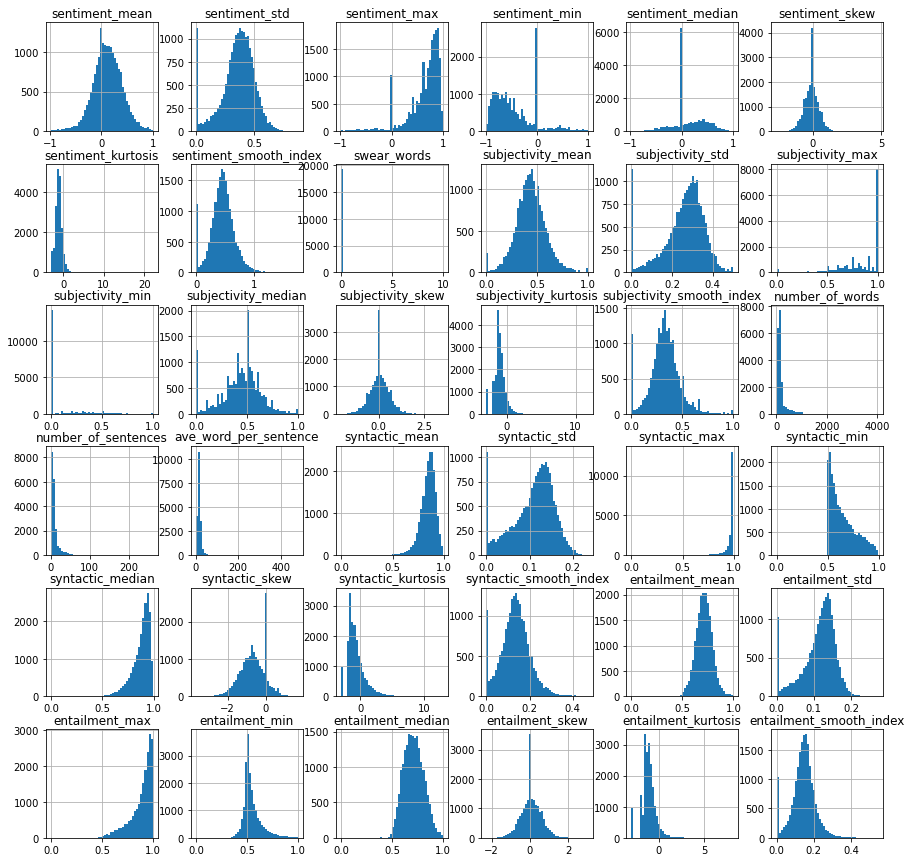

In [24]:
# plot histogram of the features
fig = plt.figure(figsize=(15,15))
ax  = fig.add_subplot(111)
all_features_sub.hist(bins=50,ax=ax)
ax.set_title('All features histogram')
plt.show()

In [25]:
# mix max the features
for col in all_features_sub.columns:
    all_features_sub[col] = (all_features_sub[col] - all_features_sub[col].min()) / (all_features_sub[col].max() - all_features_sub[col].min())

# minmax the features
for col in all_features_table.columns[1:]:
    all_features_table[col] = (all_features_table[col] - all_features_table[col].min()) / (all_features_table[col].max() - all_features_table[col].min())


/tmp/ipykernel_37644/3862138021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_sub[col] = (all_features_sub[col] - all_features_sub[col].min()) / (all_features_sub[col].max() - all_features_sub[col].min())


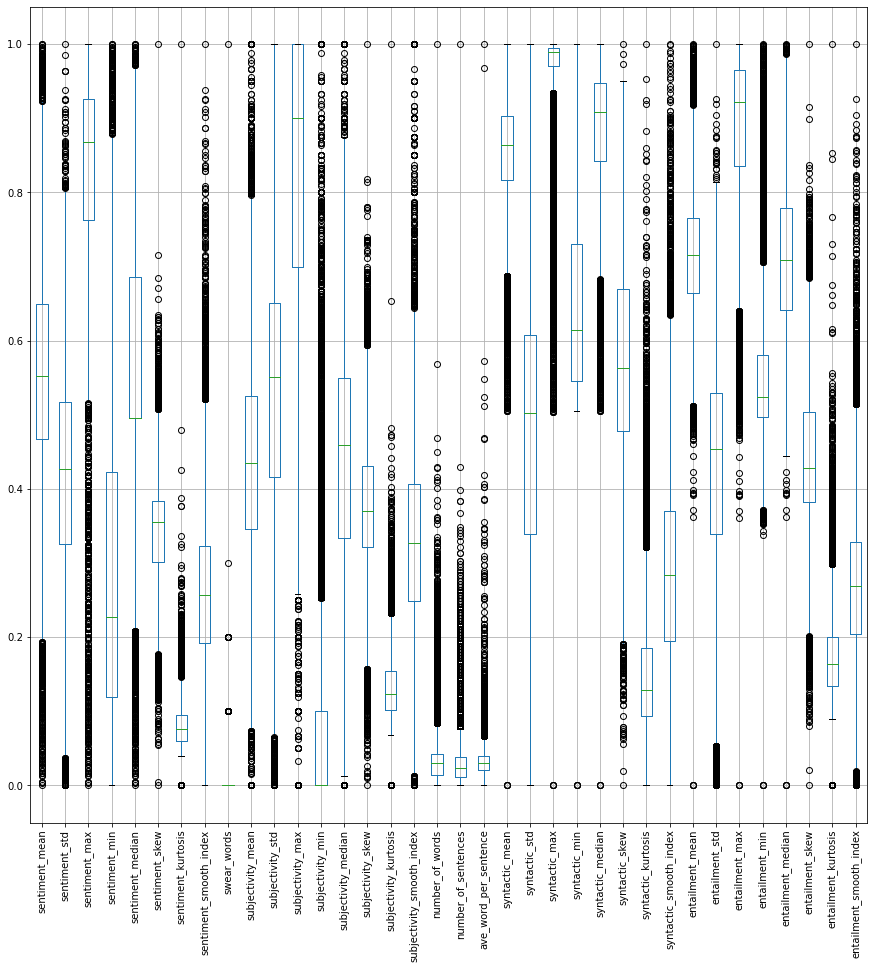

In [26]:
# plot box plots of the features
fig = plt.figure(figsize=(15,15))
ax  = fig.add_subplot(111)
all_features_sub.boxplot(ax=ax, rot=90)
plt.show()
ax.set_title('All features boxplot')
plt.show()

Visualise the correlation matrix between selected numerical features.

<AxesSubplot:>

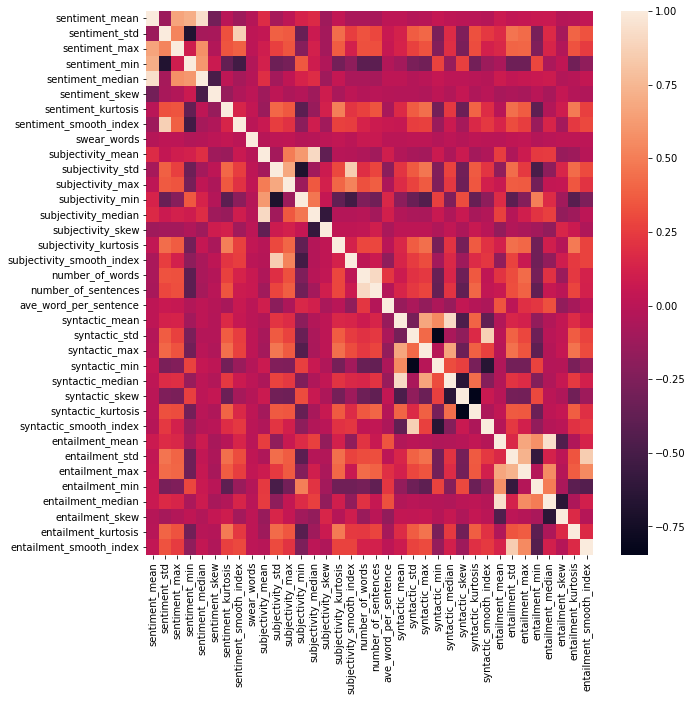

In [27]:
# plot a heatmap for the correlation matrix
fig = plt.figure(figsize=(10,10))
sns.heatmap(all_features_sub.corr(),annot=False)

The frequency of using unicode in the reviews was calculated to gauge the overall quantity of emojis and latin words that would be inputted into the `bert` model for training.

In [28]:
unicode_set = set()
for i in all_features_table["imdb_user_review"].apply(lambda x:re.findall(r'\\u.{4}', x)):
    for j in i:
        unicode_set.add(j)
print(f'The number of unicode:{format(len(unicode_set))}')

The number of unicode:196


Now, we check whether these features can distinguish the labels well. PCA was implemented to reduce all of the features to 2 dimensions and plot the 2D scatter plot.


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

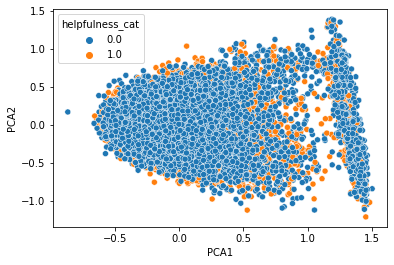

In [29]:
# Reduce the dimension of the data to 2 and visualize the data
pca= PCA(n_components=2)

pac_2 = pca.fit_transform(all_features_table.drop(['helpfulness_cat','imdb_user_review'], axis=1))
pca_table = pd.DataFrame(pac_2, columns=['PCA1', 'PCA2'])
pca_table['helpfulness_cat'] = all_features_table['helpfulness_cat']

sns.scatterplot(x="PCA1", y="PCA2",hue="helpfulness_cat",data=pca_table)


In addition, the kernel PCA was implemented and the 2D scatter plot was plotted.

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

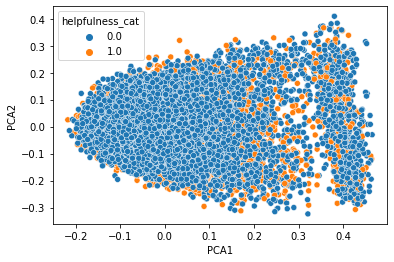

In [30]:
# Reduce the dimension of the data to 2 and visualize the data
pca= KernelPCA(n_components=2,kernel="rbf",gamma=0.1)

pac_2 = pca.fit_transform(all_features_table.drop(['helpfulness_cat','imdb_user_review'], axis=1))
pca_table = pd.DataFrame(pac_2, columns=['PCA1', 'PCA2'])
pca_table['helpfulness_cat'] = all_features_table['helpfulness_cat']

sns.scatterplot(x="PCA1", y="PCA2",hue="helpfulness_cat",data=pca_table)

# Part 7: Train the models and find the best hyperparameters of each model.


The following models were trained and tuned:
- Logistic Regression
- Random Forest
- Simple Neural Network
- Convolutional Neural Network
- BERT Transfer Learning Model

5 fold Cross-validation was implemented to evaluate the robustness of the models based on the predicted probabilites.

To make the this jupyter-notebook more readable, the code for model training was encapsulated in modules under `classification.py` and the implementation of 5 fold cross validation to the models can be found in `cross_validation.py`.

In [34]:
# load dataframe of text reviews and generated features
dfm_all_features = pd.read_csv('data/dfm_all_features.csv')
# minmax the features
for col in dfm_all_features.columns[6:]:
    dfm_all_features[col] = (dfm_all_features[col] - dfm_all_features[col].min()) / (dfm_all_features[col].max() - dfm_all_features[col].min())


/tmp/ipykernel_37644/3993024286.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  dfm_all_features = pd.read_csv('data/dfm_all_features.csv')


In [35]:
# select the generated features for training
features = dfm_all_features.columns[6:]
features

Index(['ability', 'able', 'absolute', 'absolutely', 'accept', 'account',
       'accurate', 'act', 'acted', 'acting',
       ...
       'topic_89', 'topic_90', 'topic_91', 'topic_92', 'topic_93', 'topic_94',
       'topic_95', 'topic_96', 'topic_97', 'topic_98'],
      dtype='object', length=1402)

In [36]:
# create a performance table to compare the performance of the models
performance_table = pd.DataFrame()

## 7.1 Logistic Regression

Train Logistic Regression with the following features

In [37]:
# train 5 fold logistic regression model
cv_lr = CrossValidation(LogisticRegression,'logistic_resgression',dfm_all_features,features)
dfm_all_features = cv_lr.run()

  0%|          | 0/5 [00:00<?, ?it/s]/home/tiresias/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 20%|██        | 1/5 [00:02<00:10,  2.74s/it]/home/tiresias/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

## 7.2 Random Forest

Train the random forest with the following features

In [38]:
# train 5 fold random forest model
cv_rf = CrossValidation(RandomForest,'random_forest',dfm_all_features,features)
dfm_all_features = cv_rf.run()

100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


## 7.3 Simple Neural Network

Train the simple neural network with the following features

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
278/278 [==============================] - 2s 5ms/step - loss: 0.5511 - accuracy: 0.7002 - val_loss: 0.4491 - val_accuracy: 0.7866
Epoch 2/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3635 - accuracy: 0.8404 - val_loss: 0.4026 - val_accuracy: 0.8106
Epoch 3/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2958 - accuracy: 0.8729 - val_loss: 0.4020 - val_accuracy: 0.8106
Epoch 4/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2193 - accuracy: 0.9125 - val_loss: 0.4613 - val_accuracy: 0.8065
Epoch 5/50
278/278 [==============================] - 1s 4ms/step - loss: 0.1352 - accuracy: 0.9482 - val_loss: 0.5046 - val_accuracy: 0.8385
Epoch 6/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0663 - accuracy: 0.9790 - val_loss: 0.5390 - val_accuracy: 0.8327
Epoch 7/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.6476 - val_accuracy: 0.8336
Epoch 

 20%|██        | 1/5 [00:10<00:41, 10.49s/it]

Epoch 1/50
278/278 [==============================] - 1s 4ms/step - loss: 0.5492 - accuracy: 0.6975 - val_loss: 0.4162 - val_accuracy: 0.8082
Epoch 2/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3733 - accuracy: 0.8409 - val_loss: 0.3899 - val_accuracy: 0.8141
Epoch 3/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2991 - accuracy: 0.8751 - val_loss: 0.3598 - val_accuracy: 0.8285
Epoch 4/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2154 - accuracy: 0.9129 - val_loss: 0.4077 - val_accuracy: 0.8403
Epoch 5/50
278/278 [==============================] - 1s 4ms/step - loss: 0.1196 - accuracy: 0.9591 - val_loss: 0.4686 - val_accuracy: 0.8506
Epoch 6/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0695 - accuracy: 0.9770 - val_loss: 0.5270 - val_accuracy: 0.8601
Epoch 7/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0454 - accuracy: 0.9840 - val_loss: 0.5991 - val_accuracy: 0.8619
Epoch 

 40%|████      | 2/5 [00:20<00:30, 10.32s/it]

Epoch 1/50
278/278 [==============================] - 2s 4ms/step - loss: 0.5543 - accuracy: 0.7025 - val_loss: 0.4027 - val_accuracy: 0.8151
Epoch 2/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3698 - accuracy: 0.8413 - val_loss: 0.3859 - val_accuracy: 0.8187
Epoch 3/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2997 - accuracy: 0.8744 - val_loss: 0.3504 - val_accuracy: 0.8466
Epoch 4/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2246 - accuracy: 0.9133 - val_loss: 0.3915 - val_accuracy: 0.8363
Epoch 5/50
278/278 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.9495 - val_loss: 0.4366 - val_accuracy: 0.8498
Epoch 6/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0846 - accuracy: 0.9712 - val_loss: 0.4525 - val_accuracy: 0.8539
Epoch 7/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.6291 - val_accuracy: 0.8399
Epoch 

 60%|██████    | 3/5 [00:32<00:22, 11.10s/it]

Epoch 1/50
278/278 [==============================] - 2s 4ms/step - loss: 0.5535 - accuracy: 0.7052 - val_loss: 0.4215 - val_accuracy: 0.7948
Epoch 2/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3613 - accuracy: 0.8421 - val_loss: 0.3960 - val_accuracy: 0.8160
Epoch 3/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8766 - val_loss: 0.4597 - val_accuracy: 0.7916
Epoch 4/50
278/278 [==============================] - 1s 4ms/step - loss: 0.1989 - accuracy: 0.9199 - val_loss: 0.3869 - val_accuracy: 0.8327
Epoch 5/50
278/278 [==============================] - 1s 5ms/step - loss: 0.1199 - accuracy: 0.9582 - val_loss: 0.4612 - val_accuracy: 0.8336
Epoch 6/50
278/278 [==============================] - 1s 5ms/step - loss: 0.0511 - accuracy: 0.9825 - val_loss: 0.6324 - val_accuracy: 0.8412
Epoch 7/50
278/278 [==============================] - 1s 5ms/step - loss: 0.0289 - accuracy: 0.9913 - val_loss: 0.7720 - val_accuracy: 0.8295
Epoch 

 80%|████████  | 4/5 [00:45<00:11, 11.72s/it]

Epoch 1/50
278/278 [==============================] - 2s 4ms/step - loss: 0.5648 - accuracy: 0.6909 - val_loss: 0.4015 - val_accuracy: 0.8128
Epoch 2/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8364 - val_loss: 0.3608 - val_accuracy: 0.8322
Epoch 3/50
278/278 [==============================] - 1s 4ms/step - loss: 0.3109 - accuracy: 0.8621 - val_loss: 0.3521 - val_accuracy: 0.8390
Epoch 4/50
278/278 [==============================] - 1s 4ms/step - loss: 0.2327 - accuracy: 0.9101 - val_loss: 0.3754 - val_accuracy: 0.8155
Epoch 5/50
278/278 [==============================] - 1s 4ms/step - loss: 0.1516 - accuracy: 0.9400 - val_loss: 0.3655 - val_accuracy: 0.8543
Epoch 6/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0726 - accuracy: 0.9781 - val_loss: 0.4647 - val_accuracy: 0.8579
Epoch 7/50
278/278 [==============================] - 1s 4ms/step - loss: 0.0436 - accuracy: 0.9861 - val_loss: 0.5735 - val_accuracy: 0.8444
Epoch 

100%|██████████| 5/5 [00:55<00:00, 11.20s/it]


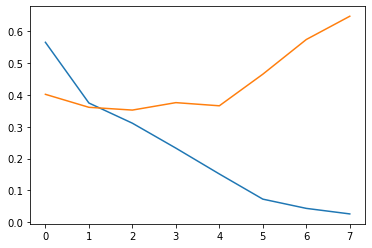

In [79]:
# train 5 fold random forest model
cv_nn = CrossValidation(NeuralNetwork,'neural_network',dfm_all_features,features,)
dfm_all_features = cv_nn.run()
cv_nn.m.model.save_weights('models/nn_model.h5')
plt.plot(cv_nn.log.history['loss'])
plt.plot(cv_nn.log.history['val_loss'])
plt.title('model loss')

## 7.4 Convolutional Neural Network

Train the convolutional neural network with the following features

In [80]:
# train 5 fold CNN model
cv_cnn = CrossValidation(CNN,'cnn',dfm_all_features,features)
dfm_all_features = cv_cnn.run()
cv_cnn.m.model.save_weights('res/cnn_model.h5')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
1109/1109 [==============================] - 7s 6ms/step - loss: 0.5511 - accuracy: 0.7104 - val_loss: 0.4873 - val_accuracy: 0.7740
Epoch 2/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4565 - accuracy: 0.7863 - val_loss: 0.4285 - val_accuracy: 0.8078
Epoch 3/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.4005 - accuracy: 0.8145 - val_loss: 0.4124 - val_accuracy: 0.8092
Epoch 4/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3777 - accuracy: 0.8304 - val_loss: 0.3814 - val_accuracy: 0.8313
Epoch 5/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3570 - accuracy: 0.8438 - val_loss: 0.3763 - val_accuracy: 0.8286
Epoch 6/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3502 - accuracy: 0.8434 - val_loss: 0.3795 - val_accuracy: 0.8286
Epoch 7/50
1109/1109 [==============================] - 7s 6ms/step - loss: 0.3321 - accuracy: 0.8560 - val_loss: 0.3796 - val_accuracy:

 20%|██        | 1/5 [01:41<06:44, 101.15s/it]

Epoch 1/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.5598 - accuracy: 0.7022 - val_loss: 0.4660 - val_accuracy: 0.7956
Epoch 2/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4655 - accuracy: 0.7798 - val_loss: 0.3951 - val_accuracy: 0.8213
Epoch 3/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4185 - accuracy: 0.8086 - val_loss: 0.3699 - val_accuracy: 0.8389
Epoch 4/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3916 - accuracy: 0.8242 - val_loss: 0.3637 - val_accuracy: 0.8461
Epoch 5/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3656 - accuracy: 0.8339 - val_loss: 0.3497 - val_accuracy: 0.8506
Epoch 6/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3592 - accuracy: 0.8442 - val_loss: 0.3443 - val_accuracy: 0.8484
Epoch 7/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3435 - accuracy: 0.8456 - val_loss: 0.3419 - val_accuracy:

 40%|████      | 2/5 [03:57<06:05, 121.98s/it]

Epoch 1/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.5543 - accuracy: 0.7043 - val_loss: 0.4602 - val_accuracy: 0.7921
Epoch 2/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4620 - accuracy: 0.7783 - val_loss: 0.3964 - val_accuracy: 0.8340
Epoch 3/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.4166 - accuracy: 0.8090 - val_loss: 0.3655 - val_accuracy: 0.8385
Epoch 4/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3852 - accuracy: 0.8223 - val_loss: 0.3593 - val_accuracy: 0.8484
Epoch 5/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3690 - accuracy: 0.8332 - val_loss: 0.3350 - val_accuracy: 0.8588
Epoch 6/50
1109/1109 [==============================] - 7s 6ms/step - loss: 0.3538 - accuracy: 0.8441 - val_loss: 0.3411 - val_accuracy: 0.8512
Epoch 7/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3388 - accuracy: 0.8489 - val_loss: 0.3307 - val_accuracy:

 60%|██████    | 3/5 [05:21<03:28, 104.40s/it]

Epoch 1/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.5575 - accuracy: 0.7086 - val_loss: 0.4667 - val_accuracy: 0.7862
Epoch 2/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.4739 - accuracy: 0.7760 - val_loss: 0.4770 - val_accuracy: 0.7659
Epoch 3/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4211 - accuracy: 0.8100 - val_loss: 0.3890 - val_accuracy: 0.8304
Epoch 4/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3794 - accuracy: 0.8294 - val_loss: 0.4061 - val_accuracy: 0.8069
Epoch 5/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3671 - accuracy: 0.8329 - val_loss: 0.3879 - val_accuracy: 0.8146
Epoch 6/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3528 - accuracy: 0.8399 - val_loss: 0.3596 - val_accuracy: 0.8345
Epoch 7/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3375 - accuracy: 0.8508 - val_loss: 0.3606 - val_accuracy:

 80%|████████  | 4/5 [07:24<01:51, 111.68s/it]

Epoch 1/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.5642 - accuracy: 0.7003 - val_loss: 0.4679 - val_accuracy: 0.7835
Epoch 2/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.4711 - accuracy: 0.7741 - val_loss: 0.4187 - val_accuracy: 0.8281
Epoch 3/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.4258 - accuracy: 0.8042 - val_loss: 0.3702 - val_accuracy: 0.8304
Epoch 4/50
1109/1109 [==============================] - 6s 5ms/step - loss: 0.3876 - accuracy: 0.8265 - val_loss: 0.3583 - val_accuracy: 0.8399
Epoch 5/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3741 - accuracy: 0.8297 - val_loss: 0.3403 - val_accuracy: 0.8507
Epoch 6/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3639 - accuracy: 0.8332 - val_loss: 0.3419 - val_accuracy: 0.8399
Epoch 7/50
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3523 - accuracy: 0.8466 - val_loss: 0.3358 - val_accuracy:

100%|██████████| 5/5 [09:56<00:00, 119.24s/it]


Text(0.5, 1.0, 'model loss')

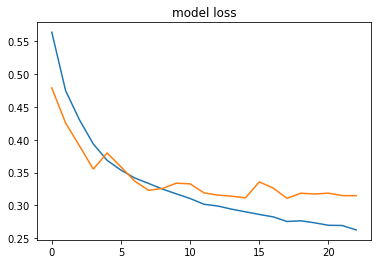

In [42]:
plt.plot(cv_cnn.log.history['loss'])
plt.plot(cv_cnn.log.history['val_loss'])
plt.title('model loss')

## 7.5 BERT Transfer Learning

This model was trained through a rented GPU, the code can be found in `BertClassifier` class in `classification.py`. The weights of the model were saved (in the models folder) for reproducibility and perform predictions.

## 7.6 CNN-GRU Model

This model was trained separately and the code can be found in `cnn_gru.ipynb`. The predictions were saved to compare against the other models.

## 7.7 Model Comparison

Read the CV performance of each models and analyse the robustness of each model.

In [81]:
# read prediction results
lr = pd.read_csv('res/test_prediction_logistic_resgression.csv')
rf = pd.read_csv('res/test_prediction_random_forest.csv')
nn = pd.read_csv('res/test_prediction_neural_network.csv')
cnn = pd.read_csv('res/test_prediction_cnn.csv')
bert = pd.read_csv('res/test_prediction_bert.csv')

# extract accuracy of the models
lr_accuracy = [accuracy_score(lr['helpfulness_cat'],lr[f'logistic_resgression_prediction_{i}']) for i in range(1,6)]
rf_accuracy = [accuracy_score(rf['helpfulness_cat'],rf[f'random_forest_prediction_{i}']) for i in range(1,6)]
nn_accuracy = [accuracy_score(nn['helpfulness_cat'],nn[f'neural_network_prediction_{i}']) for i in range(1,6)]
cnn_accuracy = [accuracy_score(cnn['helpfulness_cat'],cnn[f'cnn_prediction_{i}']) for i in range(1,6)]
bert_accuracy = [accuracy_score(bert['helpfulness_cat'],bert[f'bert_prediction_{i}']) for i in range(1,6)]

# extract f1 score of the models
lr_f1 = [f1_score(lr['helpfulness_cat'],lr[f'logistic_resgression_prediction_{i}']) for i in range(1,6)]
rf_f1 = [f1_score(rf['helpfulness_cat'],rf[f'random_forest_prediction_{i}']) for i in range(1,6)]
nn_f1 = [f1_score(nn['helpfulness_cat'],nn[f'neural_network_prediction_{i}']) for i in range(1,6)]
cnn_f1 = [f1_score(cnn['helpfulness_cat'],cnn[f'cnn_prediction_{i}']) for i in range(1,6)]
bert_f1 = [f1_score(bert['helpfulness_cat'],bert[f'bert_prediction_{i}']) for i in range(1,6)]

Visualise a boxplot to assess the accuracy of each fold each model

<AxesSubplot:>

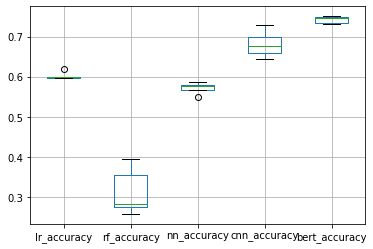

In [82]:
# boxplot of the accuracy
accuracy_table = pd.DataFrame({"lr_accuracy":lr_accuracy,"rf_accuracy":rf_accuracy,"nn_accuracy":nn_accuracy,"cnn_accuracy":cnn_accuracy,"bert_accuracy":bert_accuracy})
accuracy_table.boxplot()

Visualise a boxplot to get the F1 score of each fold of each model

<AxesSubplot:>

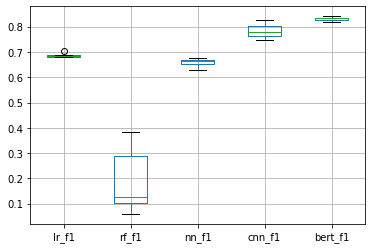

In [83]:
# boxplot of the F1 score
f1_table = pd.DataFrame({"lr_f1":lr_f1,"rf_f1":rf_f1,"nn_f1":nn_f1,"cnn_f1":cnn_f1,"bert_f1":bert_f1})
f1_table.boxplot()

# Part 8: Final Model and Conclusion

In [84]:
# create a table to store the prediction results of the three models
prediction_table = pd.DataFrame()

In [85]:
# load unlabelled data
unlabelled_data = dfm_all_features[dfm_all_features['type']=='unlabeled']
prediction_table['imdb_user_review'] = unlabelled_data['imdb_user_review']
prediction_table['_id'] = unlabelled_data['_id']
prediction_table

,imdb_user_review,_id
14311,This is basically a German takeoff on a Sherlo...,610d01fe9a63eb113d2235ac
14312,"In January of 1924, director Erich von Strohei...",610d01fe9a63eb113d224536
14313,Silent movies are not for everyone. Neither ar...,610d01fe9a63eb113d224d14
14314,It so often happens that some films take the l...,610d01fe9a63eb113d225f17
14315,I saw this film for the very first time last w...,610d01fe9a63eb113d225f1a
...,...,...
19374,Had to fast forward a few parts of the movie j...,610d02269a63eb113d5ecec2
19375,This is movie is total garbage. If I could rat...,610d02269a63eb113d5ecec4
19376,Paints court appointed guardians as completely...,610d02269a63eb113d5ececb
19377,Everyone knows how incredible and talented Ros...,610d02269a63eb113d5ed17e


In [86]:
# make predictions using BERT model
bert = BertClassifier()
bert.load_weights()
bert_pred = bert.predict(unlabelled_data)
bert_pred

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/tiresias/Desktop/NLP/modules/classification.py:306: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include 

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,


In [88]:
prediction_table['pred'] = bert_pred

In [91]:
# save the predictions
test_dfm = pd.read_csv('data/test.csv')
final_pred = test_dfm.merge(prediction_table[['_id','pred']],on='_id',how='left')
final_pred
final_pred.to_csv('data/test_prediction_bert.csv',index=False)

# Reference:
1. Zeng et al., (2014)

2. Kim et al., (2016)

3. https://stats.stackexchange.com/questions/364841/i-am-learning-to-do-stacking-i-want-to-know-what-will-the-input-be-to-level-2-c/364857

4. Multiclass Text Classification on Unbalanced, Sparse and Noisy Data Tillmann Donicke ¨1, Florian Lux2, and Matthias Damaschk3

5. Calibrating Probability with Undersampling for Unbalanced Classification     